# Kaggle实战：泰坦尼克号生存率预测

# 前言

分析工具：Python


分析思路：明确问题-理解数据-数据处理-模型构建-模型评估-方案实施

# 一、明确问题

本次的目标是对Kaggle平台上的经典案例《Titanic: Machine Learning from Disaster》，运用机器学习对乘客的生存率进行预测。

# 二、理解数据

登录Kaggle平台（https://www.kaggle.com/c/titanic/data）后在Data Description下就可下载到相应的3个数据文件：① train.csv：部分乘客的信息（包括生存状态、年龄、性别等基本信息）；② test.csv：另外部分乘客的基本信息，但是生存状态未知，需要建模预测；③ gender_submission.csv：提交结果的格式范本，必须遵守该格式


In [1]:
# 数据分析相关库
import pandas as pd
import numpy as np
import random as rnd

# 可视化相关库
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
source_df = pd.read_csv('train.csv')
predict_df = pd.read_csv('test.csv')
total_df = source_df.append(predict_df,ignore_index=True)    
#ignore_index=True的作用是拼接以后的df的index按顺序增加
#为什么要合并：在机器学习中，经常合并训练（测试）数据集和测试数据集进行同步的数据处理

查看数据的行列数

In [3]:
print(' source_df:',source_df.shape)
print(' predict_df:',predict_df.shape)
print(' total_df:',total_df.shape)

 source_df: (891, 12)
 predict_df: (418, 11)
 total_df: (1309, 12)


整体数据集total_df=原始数据集source_df+预测数据集predict_df

In [4]:
print(source_df.columns)
print(predict_df.columns)

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')
Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


原始数据集有12列（变量），预测数据集有11列（变量），其中少的正是'Survived'列（'Survived'需要我们去预测）

In [5]:
total_df.head()  

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450


In [6]:
total_df.describe()

,Age,Fare,Parch,PassengerId,Pclass,SibSp,Survived
count,1046.000000,1308.000000,1309.000000,1309.000000,1309.000000,1309.000000,891.000000
mean,29.881138,33.295479,0.385027,655.000000,2.294882,0.498854,0.383838
std,14.413493,51.758668,0.865560,378.020061,0.837836,1.041658,0.486592
min,0.170000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,21.000000,7.895800,0.000000,328.000000,2.000000,0.000000,0.000000
50%,28.000000,14.454200,0.000000,655.000000,3.000000,0.000000,0.000000
75%,39.000000,31.275000,0.000000,982.000000,3.000000,1.000000,1.000000
max,80.000000,512.329200,9.000000,1309.000000,3.000000,8.000000,1.000000


total_df.describe()默认返回数字列（数值型）的统计分析信息，其中Cabin等5列非数字列的统计分析信息无法查看，而total_df.info()可查看全部：

In [7]:
total_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
Age            1046 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Fare           1308 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


可以看出：类型为float（共3个）和int（共4个）都属于数值型变量，在模型应用时可直接使用，而类型为object（共5个）是通用的字符串类型对象，模型分析时无法识别，需先进行处理。

total_df的总体数值分布情况：

（1）数值型变量：Age/Fare/Parch/PassengerId/Pclass/SibSp/Survived（共7个）

（2）非数值型变量：Cabin/Embarked/Name/Sex/Ticket（共5个）

（3）缺失值部分Age缺失263个，Cabin缺失1014个，Embarked缺失2个，Fare缺失1个。

# 三、数据处理

# 3.1数据预处理

此处主要的预处理工作就是处理数据表格中的缺失值。对于数值型缺失值，可采用平均值填充。对于非数值型，可采用众数填充。

In [8]:
total_df['Fare']=total_df['Fare'].fillna(total_df['Fare'].mean())
total_df['Age']=total_df['Age'].fillna(total_df['Age'].mean())

In [9]:
total_df['Embarked'].mode()    #非数值型先确定众数再进行填充

0    S
dtype: object

In [10]:
total_df['Embarked']=total_df['Embarked'].fillna('S') 
total_df['Cabin']=total_df['Cabin'].fillna('U')              #'U'表示Unknown

In [11]:
total_df.info()       

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
Age            1309 non-null float64
Cabin          1309 non-null object
Embarked       1309 non-null object
Fare           1309 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


预处理以后没有发现缺失值

# 3.2初探生存率影响因素（部分）

Pclass：

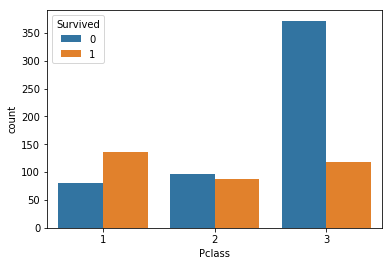

In [12]:
sns.countplot(x="Pclass", hue="Survived", data=source_df )   #source_df 含有Survivedk列

初步发现：舱位等级越高，生存率相对越高。（富有的人生存希望高一些）

Sex：

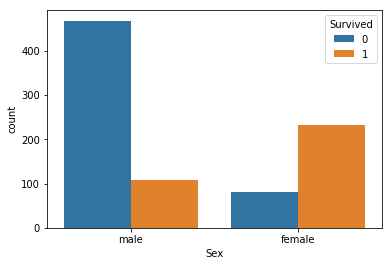

In [13]:
sns.countplot(x="Sex", hue="Survived", data=source_df )

初步发现：女性生存希望高一些。(女士优先)

Fare：

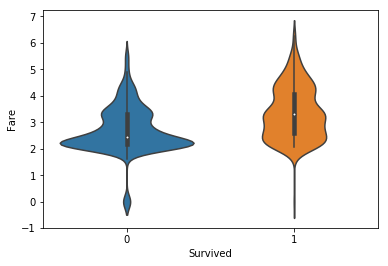

In [14]:
source_df ['Fare']=source_df ['Fare'].map(lambda x:np.log(x+1))  #numpy对数转换
sns.violinplot( x="Survived",y="Fare", data=source_df )  #小提琴图 (Violin Plot) 用于显示数据分布及其概率密度

初步发现：当log(Fare)小于2.5时，死亡率是高于生存率的，而大于2.5的生存率是高于死亡率的。（富有的人生存希望高一些）


从小提琴图中也可以看出：存活乘客票价四分位数区间范围比未存活的要大，中位数也较大。（富有的人生存希望高一些）

Embarked：

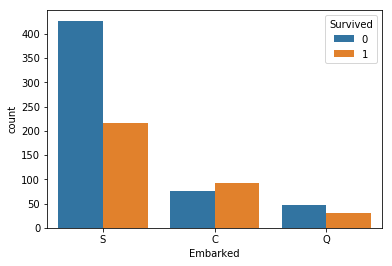

In [15]:
sns.countplot(x="Embarked", hue="Survived", data=source_df )

初步发现：C港口登船的乘客生存率高一些，S港口登船的乘客生存率最低。

SibSp：

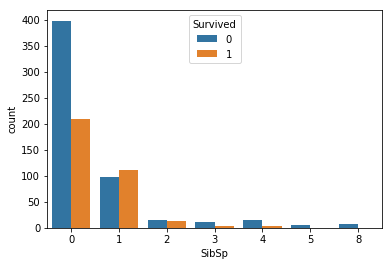

In [16]:
sns.countplot(x="SibSp", hue="Survived", data=source_df)

初步发现：大部分乘客这一属性（同代直系亲属）都为0，而SibSp数为1，2的情况下生还率会增加，SibSp再大生还率会下降。

Parch：

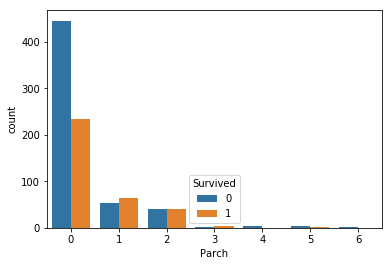

In [17]:
sns.countplot(x="Parch", hue="Survived", data=source_df)

初步发现：有不同代直系亲属的乘客的比单独旅行的幸存率要高。

Age：

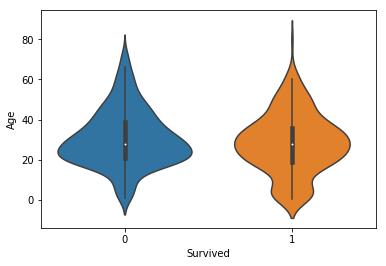

In [18]:
sns.violinplot(x="Survived",y="Age", data=source_df )       #小提琴图

初步发现：儿童未成年的孩子生存率相对高一些，其他年龄段的与生还率的关系不太清晰。两者的四分位数区间接近，中位数也接近。

# 3.3 给出假设

 根据以上的可视化分析及常理推断，给出以下假设：

假设1：生存率与Pclass、Sex、Fare、Name、Parch、SibSp、Embarked、Cabin的相关关系较强。

假设2：生存率与Age、PassengerId、Ticket的相关关系较弱。

# 3.4 特征工程

特征提取的重要性：特征工程的优劣对机器学习预测结果的影响很大。

数值型变量可直接选为特征，而非数值型变量不能被算法直接利用，应先处理后才能使用。

# 3.4.1将Cabin列重编码为虚拟变量

使用map方法将Cabin列的每个元素（字符串）首字母提取出来

In [19]:
total_df['Cabin']=total_df['Cabin'].map(lambda a:a[0])
total_df['Cabin'].value_counts()                            #在pd中用value_counts进行相同数据类型变量出现的频统计。

U    1014
C      94
B      65
D      46
E      41
A      22
F      21
G       5
T       1
Name: Cabin, dtype: int64

机器学习只能识别数值型的数据，因此还需将Cabin列的数据编码为虚拟变量，也就是变为数值型特征。使用编码虚拟变量的函数：pd.get_dummies()，此函数适合类别多于2类的数据，它会自动生成编码后的特征数据集。

In [20]:
cabin_df=pd.DataFrame()  #空DataFrame
cabin_df=pd.get_dummies(total_df['Cabin'],prefix='Cabin')   #prefix='Cabin’表示数据集的列名前缀为Cabin，total_df['Cabin']其中的元素为后缀
cabin_df.head()

,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_U
0,0,0,0,0,0,0,0,0,1
1,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,1
3,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1


In [21]:
total_df=pd.concat([total_df,cabin_df],axis=1)         #axis=1按列合并即逐行合并
total_df.drop('Cabin',axis=1,inplace=True)             #Cabin列简单处理结束，inplace=True是直接对原dataFrame进行操作，inplace=False反之。

# 3.4.2 将Embarked列重编码为虚拟变量

In [22]:
embarked_df=pd.DataFrame()
embarked_df=pd.get_dummies(total_df['Embarked'],prefix='Embarked')
embarked_df.head()

,Embarked_C,Embarked_Q,Embarked_S
0,0,0,1
1,1,0,0
2,0,0,1
3,0,0,1
4,0,0,1


In [23]:
total_df=pd.concat([total_df,embarked_df],axis=1)  
total_df.drop('Embarked',axis=1,inplace=True)       #Embarked列简单处理结束

# 3.4.3 将Name列重编码为虚拟变量

查看分析乘客姓名的特征：

In [24]:
total_df['Name'].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

每条数据都有类似格式：“姓, 头衔. 名字”，可以把“头衔”部分，通过字符串截取出来，再归类出6种类别的社会阶层！

继续用map函数，后面可接函数名执行特定操作

In [25]:
def title_split(name):
    str1=name.split(',')[1]
    str2=str1.split('.')[0]
    str3=str2.strip()   #去除字符串两侧的空格
    return str3

In [26]:
title_df=pd.DataFrame()
total_df['Title']=total_df['Name'].map(title_split)  #新增Title列
total_df['Title'].value_counts()                     #在pd中用value_counts进行相同数据类型变量出现的频数统计。

Mr              757
Miss            260
Mrs             197
Master           61
Rev               8
Dr                8
Col               4
Ms                2
Major             2
Mlle              2
Dona              1
Capt              1
the Countess      1
Jonkheer          1
Sir               1
Lady              1
Mme               1
Don               1
Name: Title, dtype: int64

将以上头衔作降维处理,，定义以下几种头衔类别，并使用map函数：

Officer政府官员；
Royalty王室（皇室）；
Mr已婚男士；
Mrs已婚妇女；
Miss年轻未婚女子；
Master有技能的人/教师

In [27]:
title_dict = {                     
                    "Capt":        "Officer",
                    "Col":         "Officer",
                    "Major":       "Officer",
                    "Jonkheer":    "Royalty",
                    "Don":         "Royalty",
                    "Sir" :        "Royalty",
                    "Dr":          "Officer",
                    "Rev":         "Officer",
                    "the Countess":"Royalty",
                    "Dona":        "Royalty",
                    "Mme":         "Mrs",
                    "Mlle":        "Miss",
                    "Ms":          "Mrs",
                    "Mr" :         "Mr",
                    "Mrs" :        "Mrs",
                    "Miss" :       "Miss",
                    "Master" :     "Master",
                    "Lady" :       "Royalty"
                    }

In [28]:
total_df['Title']=total_df['Title'].map(title_dict)
total_df['Title'].value_counts()

Mr         757
Miss       262
Mrs        200
Master      61
Officer     23
Royalty      6
Name: Title, dtype: int64

类别型变量有了，接下来释放pd.get_dummies技能，完成虚拟变量重编码。特征数据框合并原数据集，删除过渡无用变量：

In [29]:
title_df=pd.get_dummies(total_df['Title'],prefix='Title')
title_df.head()

,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty
0,0,0,1,0,0,0
1,0,0,0,1,0,0
2,0,1,0,0,0,0
3,0,0,0,1,0,0
4,0,0,1,0,0,0


In [30]:
total_df=pd.concat([total_df,title_df],axis=1)
total_df.drop(['Name','Title'],axis=1,inplace=True)
total_df.head()                                       #Name列简单处理结束

,Age,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Cabin_A,...,Cabin_U,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty
0,22.0,7.2500,0,1,3,male,1,0.0,A/5 21171,0,...,1,0,0,1,0,0,1,0,0,0
1,38.0,71.2833,0,2,1,female,1,1.0,PC 17599,0,...,0,1,0,0,0,0,0,1,0,0
2,26.0,7.9250,0,3,3,female,0,1.0,STON/O2. 3101282,0,...,1,0,0,1,0,1,0,0,0,0
3,35.0,53.1000,0,4,1,female,1,1.0,113803,0,...,0,0,0,1,0,0,0,1,0,0
4,35.0,8.0500,0,5,3,male,0,0.0,373450,0,...,1,0,0,1,0,0,1,0,0,0


# 3.4.4 将Parch列和SibSp列融合为新特征（家庭大小特征family_size）

In [31]:
family_df=pd.DataFrame()
family_df['Family_size']=total_df['Parch']+total_df['SibSp']+1  #家庭人数=同代直系亲属数（Parch）+不同代直系亲属数（SibSp）+乘客自己
family_df.head()

,Family_size
0,2
1,2
2,1
3,2
4,1


In [32]:
#对Family_size分为三个类别Family_single、Family_middle和Family_large
family_df['Family_single']=family_df['Family_size'].map(lambda s:1 if s==1 else 0 )
family_df['Family_middle']=family_df['Family_size'].map(lambda s:1 if 2<=s<=4 else 0 )
family_df['Family_large']=family_df['Family_size'].map(lambda s:1 if s>=5 else 0 )
family_df.head()

,Family_size,Family_single,Family_middle,Family_large
0,2,0,1,0
1,2,0,1,0
2,1,1,0,0
3,2,0,1,0
4,1,1,0,0


In [33]:
family_df.drop('Family_size',axis=1,inplace=True)
family_df.head()

,Family_single,Family_middle,Family_large
0,0,1,0
1,0,1,0
2,1,0,0
3,0,1,0
4,1,0,0


In [34]:
total_df=pd.concat([total_df,family_df],axis=1)
total_df.drop(['Parch','SibSp'],axis=1,inplace=True)  #Parch列与SibSp列简单处理结束

# 3.4.5 将Pclass列重编码为虚拟变量

In [35]:
pclass_df=pd.DataFrame()
pclass_df=pd.get_dummies(total_df['Pclass'],prefix='Pclass')
pclass_df.head()

,Pclass_1,Pclass_2,Pclass_3
0,0,0,1
1,1,0,0
2,0,0,1
3,1,0,0
4,0,0,1


In [36]:
total_df=pd.concat([total_df,pclass_df],axis=1)    
total_df.drop('Pclass',axis=1,inplace=True)            #Pclass列简单处理结束

# 3.4.6 将Sex列编码为类别变量

Sex列只有两种值：female和male，变量水平数=2，直接map+映射字典，变为0或1的数值类型。

In [37]:
sexmap={'male':1,'female':0}
total_df['Sex']=total_df['Sex'].map(sexmap)             #Sex列简单处理结束
total_df.head()

,Age,Fare,PassengerId,Sex,Survived,Ticket,Cabin_A,Cabin_B,Cabin_C,Cabin_D,...,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty,Family_single,Family_middle,Family_large,Pclass_1,Pclass_2,Pclass_3
0,22.0,7.2500,1,1,0.0,A/5 21171,0,0,0,0,...,1,0,0,0,0,1,0,0,0,1
1,38.0,71.2833,2,0,1.0,PC 17599,0,0,1,0,...,0,1,0,0,0,1,0,1,0,0
2,26.0,7.9250,3,0,1.0,STON/O2. 3101282,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
3,35.0,53.1000,4,0,1.0,113803,0,0,1,0,...,0,1,0,0,0,1,0,1,0,0
4,35.0,8.0500,5,1,0.0,373450,0,0,0,0,...,1,0,0,0,1,0,0,0,0,1


Ticket列忽略不计，到此为止，所有特征都已经转化为算法能识别的数据类型。

# 3.5 特征工程--选择特征

特征选取方法：根据所有变量的相关系数矩阵，筛选出与预测标签Survived最相关的特征变量。

In [38]:
r_df=total_df.corr()    #相关系数矩阵
r_df['Survived'].sort_values(ascending=False)  #只看Survived列的相关系数降序排序 ，正相关（+）和负相关（-）

Survived         1.000000
Title_Mrs        0.344935
Title_Miss       0.332795
Pclass_1         0.285904
Family_middle    0.279855
Fare             0.257307
Cabin_B          0.175095
Embarked_C       0.168240
Cabin_D          0.150716
Cabin_E          0.145321
Cabin_C          0.114652
Pclass_2         0.093349
Title_Master     0.085221
Cabin_F          0.057935
Title_Royalty    0.033391
Cabin_A          0.022287
Cabin_G          0.016040
Embarked_Q       0.003650
PassengerId     -0.005007
Cabin_T         -0.026456
Title_Officer   -0.031316
Age             -0.070323
Family_large    -0.125147
Embarked_S      -0.149683
Family_single   -0.203367
Cabin_U         -0.316912
Pclass_3        -0.322308
Sex             -0.543351
Title_Mr        -0.549199
Name: Survived, dtype: float64

根据相关系数大小，选择其中的title_df, pclass_df, family_df, cabin_df, embarked_df, Sex，Fare作为特征

同时，各个影响因素相关系数的分布与3.3中的假设基本吻合！

构建整体数据集的特征数据框full_X（包含1309行整体数据集特征），再使用loc属性拆分出891行原始数据集特征source_X和标签source_y、481行预测数据集特征pred_X:

In [39]:
full_X = pd.concat( [title_df,
                     pclass_df,
                     family_df,
                     total_df['Fare'],
                     cabin_df,
                     embarked_df,
                     total_df['Sex']
                    ] , axis=1 ) 
full_X.head()                                 #full_X为1309 rows × 26 columns

,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty,Pclass_1,Pclass_2,Pclass_3,Family_single,...,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_U,Embarked_C,Embarked_Q,Embarked_S,Sex
0,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,1,1
1,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,0,1,0,0,0,0,0,0,1,1,...,0,0,0,0,0,1,0,0,1,0
3,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,0,1,0,0,0,0,0,1,1,...,0,0,0,0,0,1,0,0,1,1


In [40]:
#原始数据集行数
source_row=891                                      #source_df.shape为（891，12）
#原始数据集：特征
source_X = full_X.loc[:source_row-1,:]              #处理后的特征     
#原始数据集：标签 
source_y = total_df.loc[:source_row-1,'Survived']   #标签只要一列'Survived'

# 四、模型构建

In [41]:
'''从原始数据集（source_df）中拆分出训练数据集（用于模型训练train的数据），测试数据集（用于模型评估test）
train_test_split是交叉验证中常用的函数，功能是从样本中随机的按比例选取train data和test data
test_size：样本占比，如果是整数的话就是样本的数量'''

from sklearn.cross_validation import train_test_split 

#建立模型用的训练数据集和测试数据集
train_X, test_X, train_y, test_y = train_test_split(source_X ,source_y,train_size=0.8)

#输出数据集大小
print ('原始数据集特征：',source_X.shape, 
       '训练数据集特征：',train_X.shape ,
       '测试数据集特征：',test_X.shape)

print ('原始数据集标签：',source_y.shape, 
       '训练数据集标签：',train_y.shape ,
       '测试数据集标签：',test_y.shape)

原始数据集特征： (891, 26) 训练数据集特征： (712, 26) 测试数据集特征： (179, 26)
原始数据集标签： (891,) 训练数据集标签： (712,) 测试数据集标签： (179,)


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# 五、评估模型

本例是分类问题：逻辑回归最常见方法

In [42]:
#逻辑回归
from sklearn.linear_model import LogisticRegression
logisticR=LogisticRegression()
logisticR.fit(train_X,train_y)
logisticR_score=logisticR.score(test_X,test_y)
logisticR_score

0.88826815642458101

# 六、方案实施

根据以上各算法的准确率排名，选择准确率较高的算法LogisticRegression对数据进行预测。

In [43]:
pred_X = full_X.loc[source_row:,:]    #使用loc属性从full_X拆分出481行预测数据集特征pred_X
pred_Y = logisticR.predict(pred_X)
pred_Y = pred_Y.astype(int)
passenger_id = total_df.loc[source_row:,'PassengerId']
pred_df = pd.DataFrame({'PassengerId':passenger_id,
                       'Survived':pred_Y})
pred_df.shape
pred_df.head()
pred_df.to_csv('titanic_pred.csv',index=False)

# 七、总结

本例为简单的机器学习小案例，旨在了解机器学习的流程和特征的选取方法：明确问题-理解数据-数据处理-模型构建-模型评估-方案实施。

在数据处理阶段，将现有数据转换成模型能够直接利用的数值型数据，并选择相关系数较大的几个特征作为目标特征。

在模型构建阶段，选择了线性回归、逻辑回归、随机森林、高斯朴素贝叶斯、支持向量机SVC、knn等常见的模型进行预测。

案例涉及到的数据处理技巧：

（1）Series的map方法：高效、快速地批量处理列数据，也适用二水平分类数据的编码（通过字典映射）

（2）pd.get_dummies方法：适用多水平分类数据的虚拟编码，premix表示增加变量名前缀

（3）lambda匿名函数：高效、快速地批量处理，配合map一起使用更佳

（4）pd.concat方法：axis=1逐行合并

（5）df.drop('column', axis=1,inplace=True)对现有的DF删除无用变量

（6）df1.append(df2, ignore_index=True)数据集逐行合并， ignore_index=True的作用是拼接以后index按顺序增加